<a href="https://colab.research.google.com/github/jvpalhares/IA353-vonzuben-pc2-2023.1/blob/main/PC2_Ativ6_RNNs_MLP_LP_TS_Unemployment_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Notebook #6**
## Simple Recurrent Neural Network, Linear Predictor, MLP, ESN and LSTM for multi-step time series prediction.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** João Victor Palhares Barbosa


In [ ]:
# Loading all the relevant libraries
from pandas import read_csv
from pandas import DataFrame
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

## **A base [unemployment rate] foi baixada no [link](https://fred.stlouisfed.org/series/UNRATE).**

In [ ]:
# Structuring the dataset from a single time series, scaling and spliting into training / testing
def get_train_test(dataset, split_percent, time_steps, horizon):
    df = read_csv(dataset, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    # There is a kind of data leakage in the next command
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    df = DataFrame()
    for i in range(0,time_steps):
      df['t-' + str(time_steps-i-1)] = [data[j] for j in range(i, (len(data)-horizon-time_steps+i+1))]
    for i in range(1,horizon+1):
      df['t+' + str(i)] = [data[j] for j in range(time_steps+i-1, (len(data)-horizon+i))]
    print(df)
    df1 = df.copy()
    for i in range(1,horizon+1):
      df1 = df1.drop(['t+' + str(i)], axis = 1)
    dataX = np.array(df1)
    df2 = df['t+1']
    for i in range(2,horizon+1):
      df2 = pd.concat([df2, df['t+' + str(i)]], axis=1)
    datay = np.array(df2)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    X = dataX[range(split),:]
    y = datay[range(split)]
    Xt = dataX[split:,:]
    yt = datay[split:]
    return X, y, Xt, yt

In [ ]:
time_steps = 11
horizon = 3

**(A)** Explique o papel dos parâmetros de projeto **time_steps** e **horizon**.


O parâmetro **time_steps** indica o **número de passos de tempo anteriores que serão usados como entradas para prever o próximo valor** no modelo de previsão de séries temporais. Por exemplo, se **time_steps** for definido como **11**, o modelo utilizará os **11** valores anteriores para prever o próximo valor. Esses valores anteriores são armazenados nas colunas **"t-10", "t-9", ..., "t-1"** do DataFrame criado.

Já o parâmetro **horizon** indica **quantos passos de tempo à frente serão previstos** pelo modelo. Por exemplo, se **horizon** for definido como **3**, o modelo será treinado para prever os valores **1, 2 e 3** passos à frente com base nos valores anteriores. Esses valores são armazenados nas colunas **"t+1", "t+2" e "t+3"** do DataFrame criado.

Portanto, o **time_steps define quantos passos de tempo anteriores** são considerados como entrada e o **horizon define quantos passos de tempo à frente** serão previstos pelo modelo.

# Mounting the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Here you will decide which dataset to consider.
X, y, Xt, yt = get_train_test('/content/drive/MyDrive/Colab Notebooks/unemployment_rate.csv', 0.8, time_steps, horizon)
# X, y, Xt, yt = get_train_test('monthly_sunspot.csv', 0.8, time_steps, horizon)

         t-10       t-9       t-8       t-7       t-6       t-5       t-4  \
0    0.073770  0.106557  0.122951  0.114754  0.081967  0.090164  0.090164   
1    0.106557  0.122951  0.114754  0.081967  0.090164  0.090164  0.114754   
2    0.122951  0.114754  0.081967  0.090164  0.090164  0.114754  0.106557   
3    0.114754  0.081967  0.090164  0.090164  0.114754  0.106557  0.098361   
4    0.081967  0.090164  0.090164  0.114754  0.106557  0.098361  0.106557   
..        ...       ...       ...       ...       ...       ...       ...   
873  0.360656  0.344262  0.344262  0.319672  0.303279  0.286885  0.286885   
874  0.344262  0.344262  0.319672  0.303279  0.286885  0.286885  0.270492   
875  0.344262  0.319672  0.303279  0.286885  0.286885  0.270492  0.278689   
876  0.319672  0.303279  0.286885  0.286885  0.270492  0.278689  0.237705   
877  0.303279  0.286885  0.286885  0.270492  0.278689  0.237705  0.221311   

          t-3       t-2       t-1       t-0       t+1       t+2       t+3  

##**Implementing the simple recurrent neural network (Simple RNN)**

In [ ]:
# Execute this cell or the cell associated with one of the other predictors. They are mutually exclusive.
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, activation=activation[0], input_shape=input_shape))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model = create_RNN(hidden_units=30, dense_units=horizon, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
train_predict = model.fit(X, y, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
712/712 - 8s - loss: 0.0036 - 8s/epoch - 11ms/step
Epoch 2/20
712/712 - 4s - loss: 0.0010 - 4s/epoch - 5ms/step
Epoch 3/20
712/712 - 3s - loss: 8.4931e-04 - 3s/epoch - 5ms/step
Epoch 4/20
712/712 - 4s - loss: 8.0834e-04 - 4s/epoch - 5ms/step
Epoch 5/20
712/712 - 3s - loss: 7.4525e-04 - 3s/epoch - 4ms/step
Epoch 6/20
712/712 - 2s - loss: 7.3385e-04 - 2s/epoch - 3ms/step
Epoch 7/20
712/712 - 2s - loss: 6.9976e-04 - 2s/epoch - 2ms/step
Epoch 8/20
712/712 - 2s - loss: 7.3416e-04 - 2s/epoch - 2ms/step
Epoch 9/20
712/712 - 2s - loss: 6.9830e-04 - 2s/epoch - 3ms/step
Epoch 10/20
712/712 - 2s - loss: 7.1882e-04 - 2s/epoch - 3ms/step
Epoch 11/20
712/712 - 2s - loss: 6.8489e-04 - 2s/epoch - 3ms/step
Epoch 12/20
712/712 - 2s - loss: 6.8534e-04 - 2s/epoch - 2ms/step
Epoch 13/20
712/712 - 1s - loss: 7.1225e-04 - 1s/epoch - 2ms/step
Epoch 14/20
712/712 - 2s - loss: 6.9793e-04 - 2s/epoch - 2ms/step
Epoch 15/20
712/712 - 2s - loss: 6.7522e-04 - 2s/epoch - 2ms/step
Epoch 16/20
712/712 - 2s -

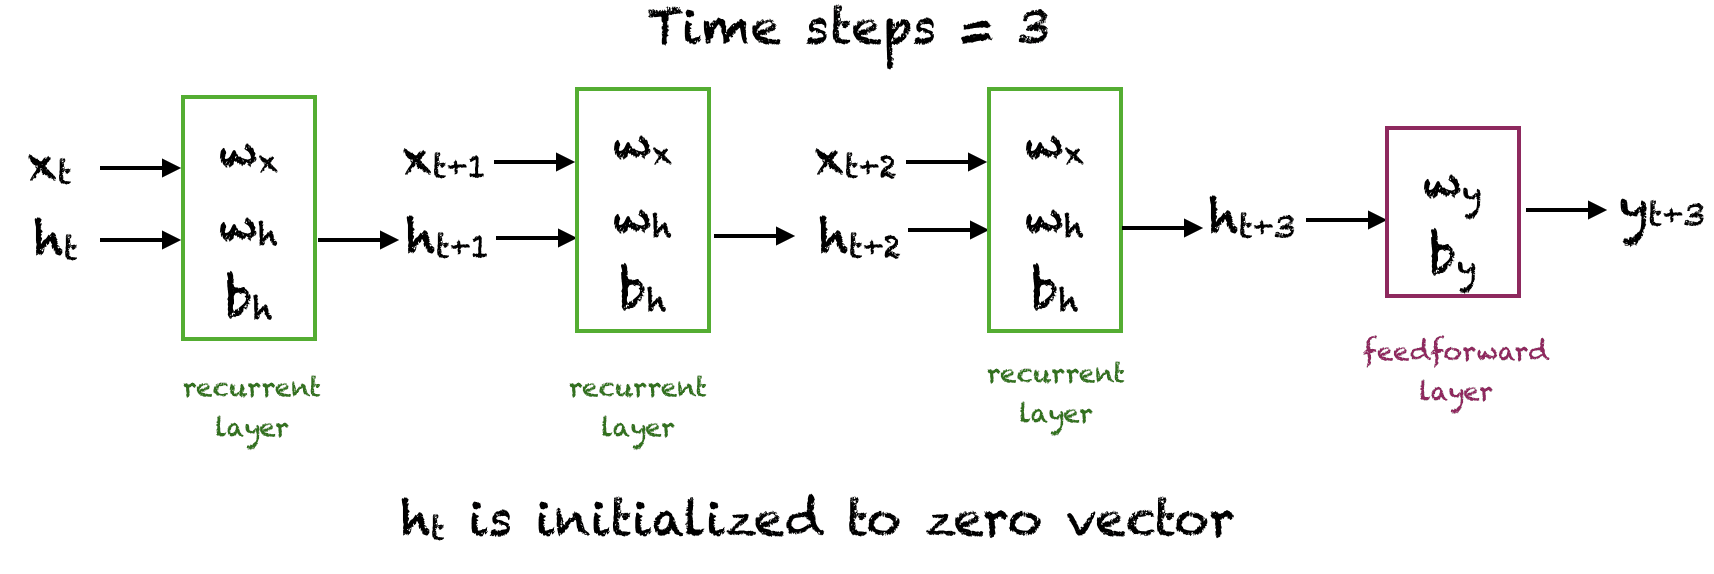

In [ ]:
# Do not run this cell or upload the PNG file and then run.
# Configuration of the simple RNN
from IPython.display import Image
Image("/content/drive/MyDrive/Colab Notebooks/RNN_info_flow.png", width = 600, height = 300)

**(B)** Explique o fluxo de informação da figura **RNN_info_flow.png**, correspondente à
rede neural SimpleRNN, e explique as dimensões da SimpleRNN (última célula
do notebook).


A imagem **RNN_info_flow.png** representa o fluxo de informação em uma rede neural **SimpleRNN** com um número de **camadas recorrentes igual a 3** e **uma camada de alimentação direta (feedforward layer)**.

A cada passo de tempo, representado pelas setas verticais, a entrada ***xt*** e o estado oculto anterior ***ht*** são combinados através de uma multiplicação de matrizes, usando os pesos ***wx***, ***wh*** e o viés ***bh***, na camada recorrente. Isso produz uma nova representação ***ht+1*** do estado oculto.

Essa operação é repetida **para cada passo de tempo subsequente**, onde o estado oculto ***ht+1*** é usado como entrada junto com a próxima entrada ***xt+1*** para calcular o novo estado oculto ***ht+2***, e assim por diante, até o último passo de tempo ***ht+3***.

Finalmente, na última etapa de tempo, o estado oculto ***ht+3*** é passado para a camada de alimentação direta (feedforward layer), onde é combinado com os pesos ***wy*** e o viés ***by*** para produzir a saída final da rede neural = ***yt+3***.

Além disso, é importante observar que o estado oculto ***ht*** é inicializado como um vetor de zeros antes de começar o processo de cálculo em cada etapa de tempo. Isso permite que a rede capture informações e dependências sequenciais ao longo do tempo, atualizando o estado oculto a cada passo.

--

Na rede neural SimpleRNN mostrada, as dimensões dos pesos são as seguintes:

* **wx** (pesos da entrada para o estado oculto): (1, 100)

  A matriz de pesos **wx** tem uma dimensão de (1, 100), onde 1 representa a dimensão da entrada (no caso, temos apenas uma entrada) e 100 representa o número de unidades ocultas na camada recorrente.

* **wh** (pesos do estado oculto anterior para o estado oculto atual): (25, 100)

  A matriz de pesos **wh** tem uma dimensão de (25, 100), onde 25 representa o número de unidades ocultas na camada recorrente e 100 representa o número de unidades ocultas na camada atual.

* **bh** (viés do estado oculto): (100,)

  O vetor de viés **bh** tem uma dimensão de (100,), correspondente ao número de unidades ocultas na camada recorrente.

* **wy** (pesos do estado oculto para a saída): (25, 3)

  A matriz de pesos **wy** tem uma dimensão de (25, 3), onde 25 representa o número de unidades ocultas na camada recorrente e 3 representa a dimensão da saída (no caso, temos 3 saídas).

* **by** (viés da saída): (3,)

  O vetor de viés **by** tem uma dimensão de (3,), correspondente ao número de saídas.

Essas dimensões refletem a arquitetura da rede neural SimpleRNN e a quantidade de unidades ocultas e dimensões de entrada/saída especificadas durante a criação do modelo.

##**Implementing a linear predictor (LP)**

In [ ]:
# Execute this cell or the cell associated with one of the other predictors. They are mutually exclusive.

model = LinearRegression()
train_predict = model.fit(X, y)
print(model.coef_)
print(model.intercept_)

[[ 0.12196004 -0.12328792 -0.01693552  0.05766343 -0.04293827 -0.11993492
   0.0259988  -0.07539273 -0.06123849  0.24181321  0.97494787]
 [ 0.08115055  0.04347511 -0.13333121  0.03236612  0.01148157 -0.1552238
  -0.09851621 -0.04648702 -0.13729148  0.1737857   1.1940533 ]
 [ 0.2204856  -0.13287772  0.00335937 -0.06602021 -0.02121115 -0.1229253
  -0.11382751 -0.18259901 -0.1276789   0.15079425  1.3391854 ]]
[0.00451538 0.00895284 0.01383103]


##**Implementing the multilayer perceptron neural network (MLP)**

In [ ]:
# Execute this cell or the cell associated with one of the other predictors. They are mutually exclusive.

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(80, activation=tf.nn.tanh),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(horizon, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error')
train_predict = model.fit(X, y, epochs=100)
model.summary()

Epoch 1/100
23/23 [==============================] - 1s 2ms/step - loss: 0.1107
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 11/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 12/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 13/100
23/23 [=================

##**Implementing the echo state neural network (ESN)**

In [ ]:
# Execute this cell or the cell associated with one of the other predictors. They are mutually exclusive.
!git clone https://github.com/cknd/pyESN.git
!cp /content/pyESN/pyESN.py .
from pyESN import ESN

Cloning into 'pyESN'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (106/106), 1.17 MiB | 3.16 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
model = ESN(n_inputs = time_steps,
          n_outputs = horizon,
          n_reservoir = 500,
          spectral_radius = 2,
          random_state=42)
model.fit(X,y)

array([[0.08384361, 0.07783336, 0.0751864 ],
       [0.16029758, 0.19713126, 0.21083233],
       [0.17801997, 0.19914489, 0.22539668],
       ...,
       [0.20206954, 0.20116721, 0.21326122],
       [0.19680793, 0.21271109, 0.20128283],
       [0.21094809, 0.20299064, 0.23326046]])

##**Implementing the long short-term memory network (LSTM)**

In [ ]:
X1 = X.reshape(X.shape[0],time_steps,1)
model=Sequential()
model.add(LSTM(25,input_shape=(time_steps,1)))
model.add(Dense(horizon,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

train_predict = model.fit(X1,y,epochs=100,verbose=2)
print(model.summary())

Epoch 1/100
23/23 - 3s - loss: 0.0319 - 3s/epoch - 137ms/step
Epoch 2/100
23/23 - 0s - loss: 0.0053 - 133ms/epoch - 6ms/step
Epoch 3/100
23/23 - 0s - loss: 0.0041 - 140ms/epoch - 6ms/step
Epoch 4/100
23/23 - 0s - loss: 0.0034 - 141ms/epoch - 6ms/step
Epoch 5/100
23/23 - 0s - loss: 0.0031 - 138ms/epoch - 6ms/step
Epoch 6/100
23/23 - 0s - loss: 0.0028 - 133ms/epoch - 6ms/step
Epoch 7/100
23/23 - 0s - loss: 0.0027 - 157ms/epoch - 7ms/step
Epoch 8/100
23/23 - 0s - loss: 0.0026 - 137ms/epoch - 6ms/step
Epoch 9/100
23/23 - 0s - loss: 0.0025 - 139ms/epoch - 6ms/step
Epoch 10/100
23/23 - 0s - loss: 0.0024 - 133ms/epoch - 6ms/step
Epoch 11/100
23/23 - 0s - loss: 0.0024 - 146ms/epoch - 6ms/step
Epoch 12/100
23/23 - 0s - loss: 0.0022 - 141ms/epoch - 6ms/step
Epoch 13/100
23/23 - 0s - loss: 0.0021 - 148ms/epoch - 6ms/step
Epoch 14/100
23/23 - 0s - loss: 0.0021 - 139ms/epoch - 6ms/step
Epoch 15/100
23/23 - 0s - loss: 0.0020 - 138ms/epoch - 6ms/step
Epoch 16/100
23/23 - 0s - loss: 0.0019 - 134ms/epo

In [ ]:
def print_error(trainY, testY, train_predict, test_predict,i):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('t+%d RMSE train: %.3f RMSE' % (i+1, train_rmse))
    print('t+%d RMSE test: %.3f RMSE' % (i+1, test_rmse))

# Make predictions
train_predict = model.predict(X)
test_predict = model.predict(Xt)

for i in range(horizon):
  if(horizon == 1):
    y1_pred = train_predict
    y1_pred_t = test_predict
    y1 = y
    y1_t = yt
  elif(horizon > 1):
    y1_pred = train_predict[:,i]
    y1_pred_t = test_predict[:,i]
    y1 = y[:,i]
    y1_t = yt[:,i]
  print_error(y1, y1_t, y1_pred, y1_pred_t,i)

6/6 [==============================] - 0s 3ms/step
t+1 RMSE train: 0.017 RMSE
t+1 RMSE test: 0.086 RMSE
t+2 RMSE train: 0.024 RMSE
t+2 RMSE test: 0.117 RMSE
t+3 RMSE train: 0.032 RMSE
t+3 RMSE test: 0.142 RMSE


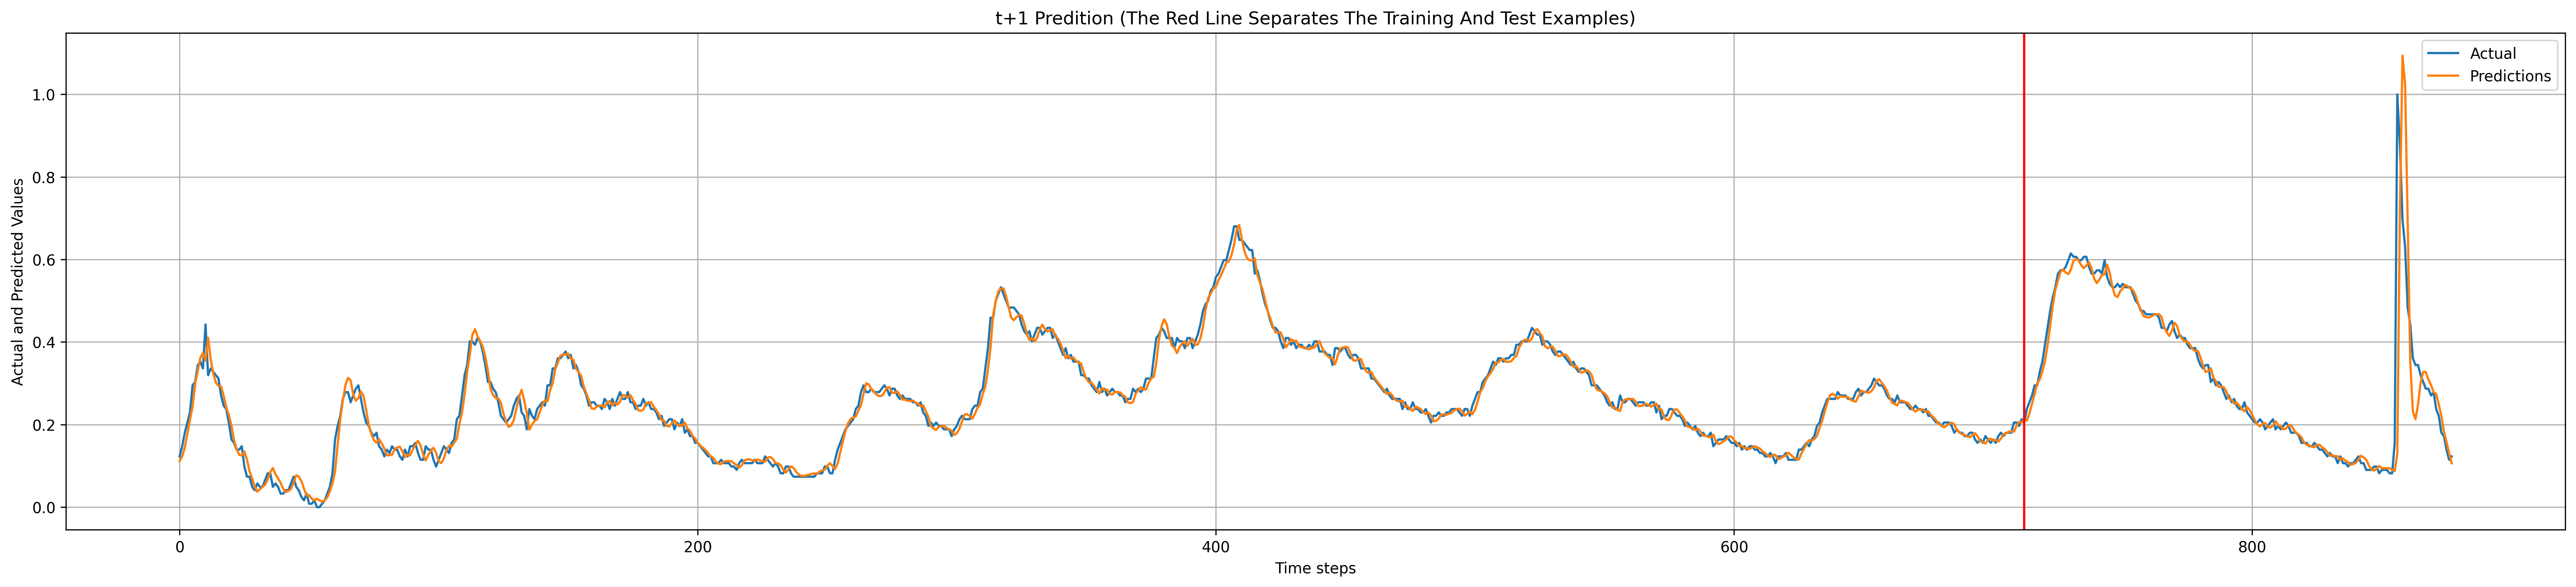

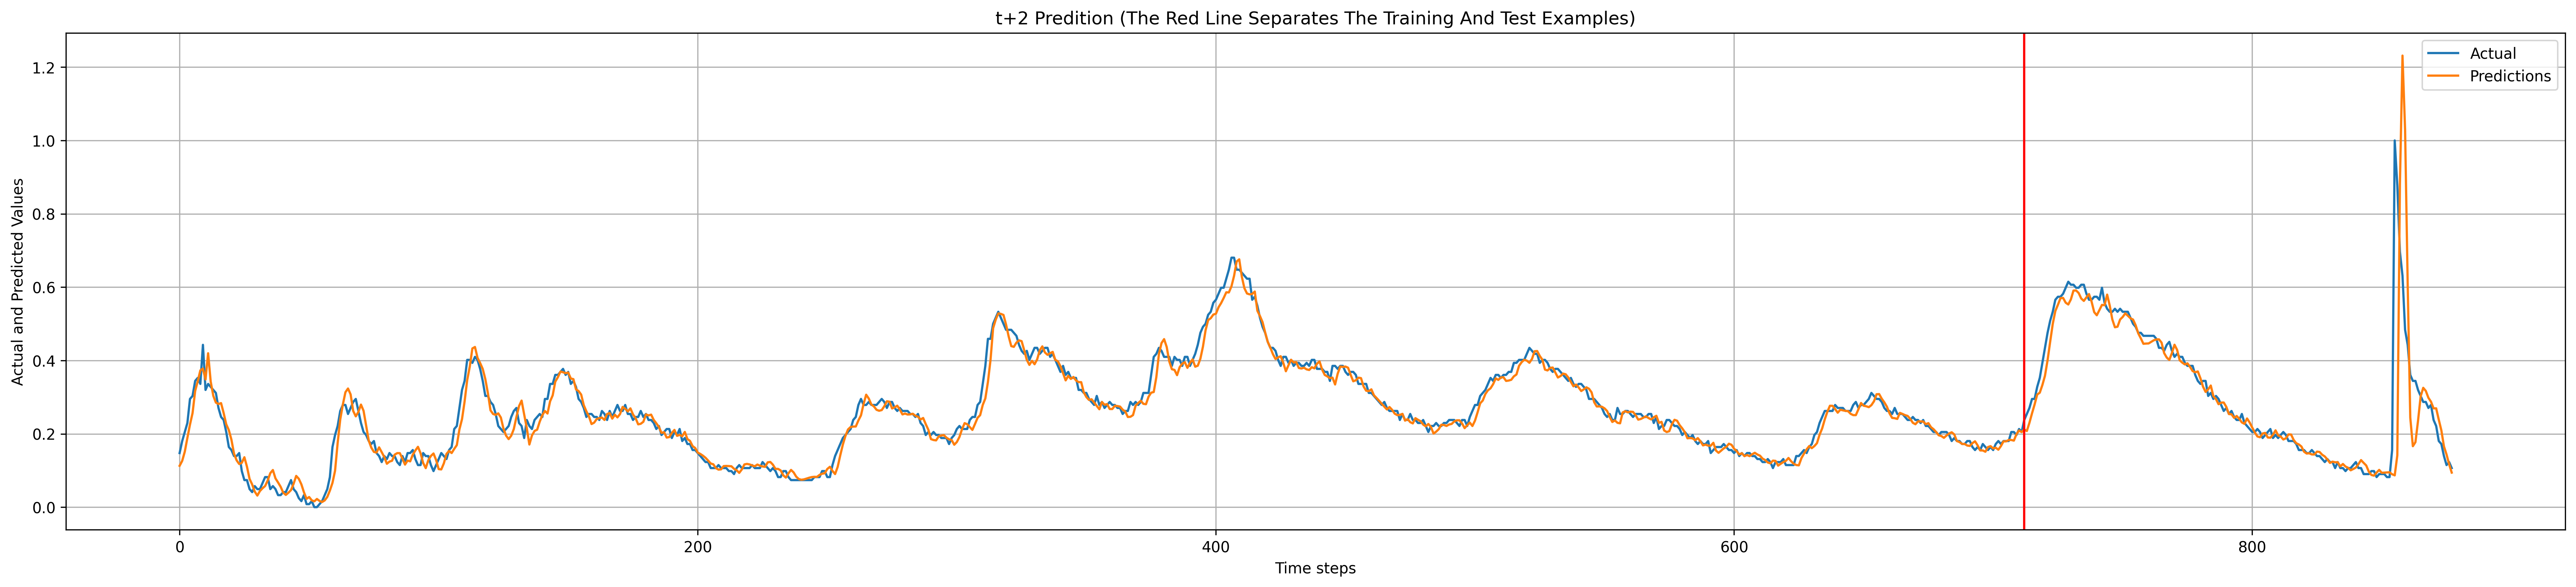

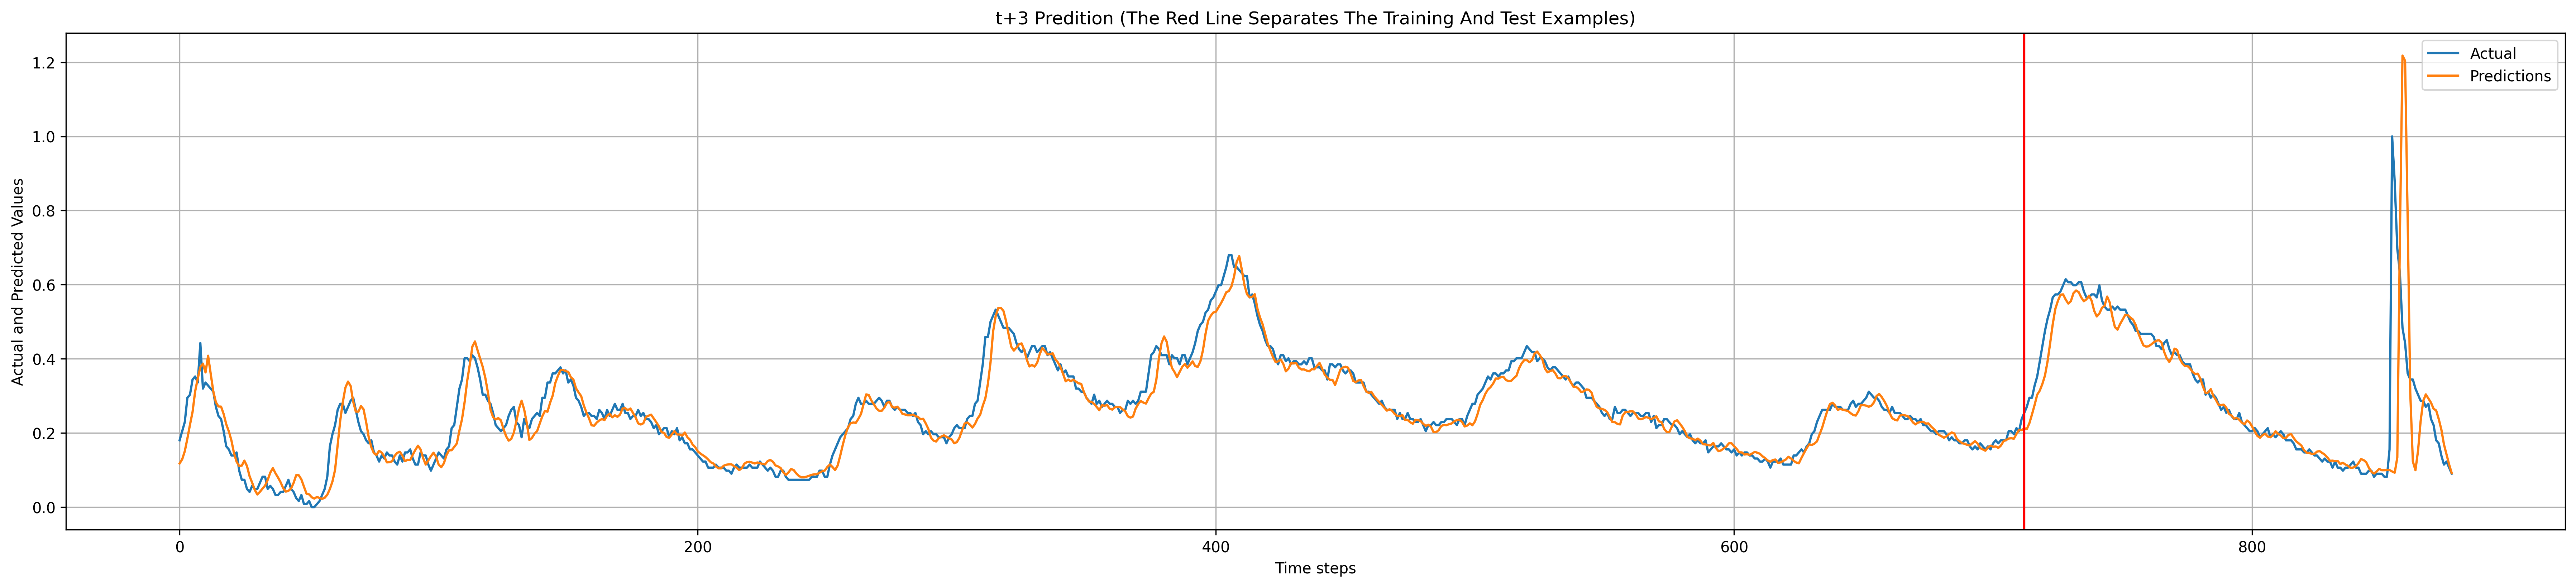

In [ ]:
# Plot the predictions together with the actual values
def plot_result(trainY, testY, train_predict, test_predict,i):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(30, 6), dpi=300)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Time steps')
    plt.ylabel('Actual and Predicted Values')
    plt.title('t+%d Predition (The Red Line Separates The Training And Test Examples)' % (i+1))
    plt.grid(True)

for i in range(horizon):
  if(horizon == 1):
    y1_pred = train_predict
    y1_pred_t = test_predict
    y1 = y
    y1_t = yt
  elif(horizon > 1):
    y1_pred = train_predict[:,i]
    y1_pred_t = test_predict[:,i]
    y1 = y[:,i]
    y1_t = yt[:,i]
  plot_result(y1, y1_t, y1_pred, y1_pred_t,i)

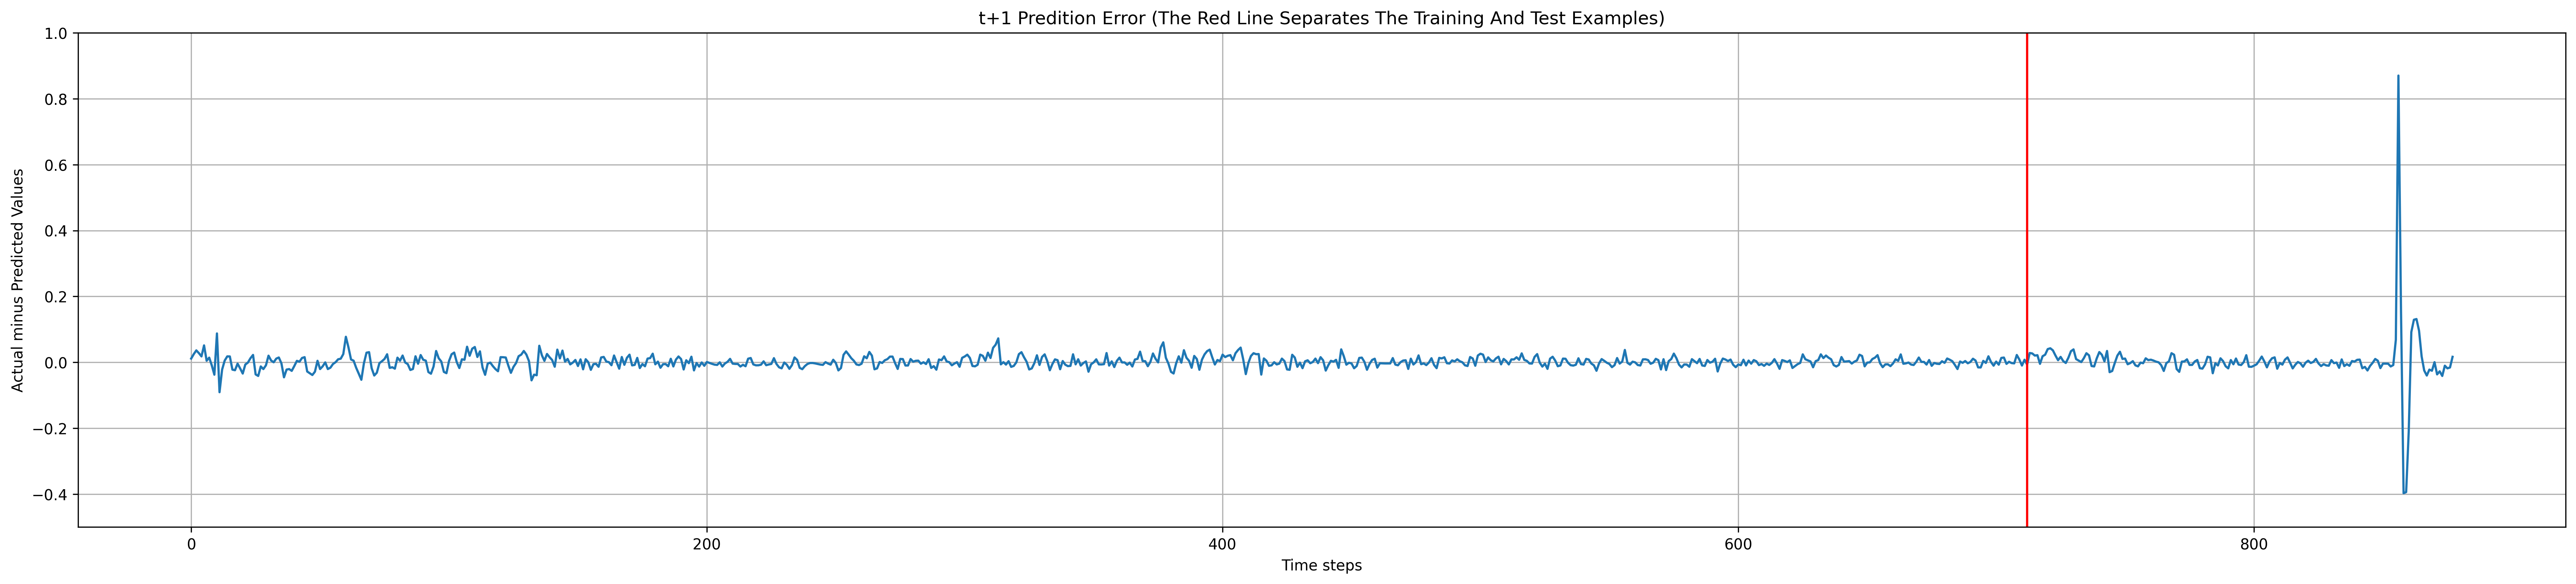

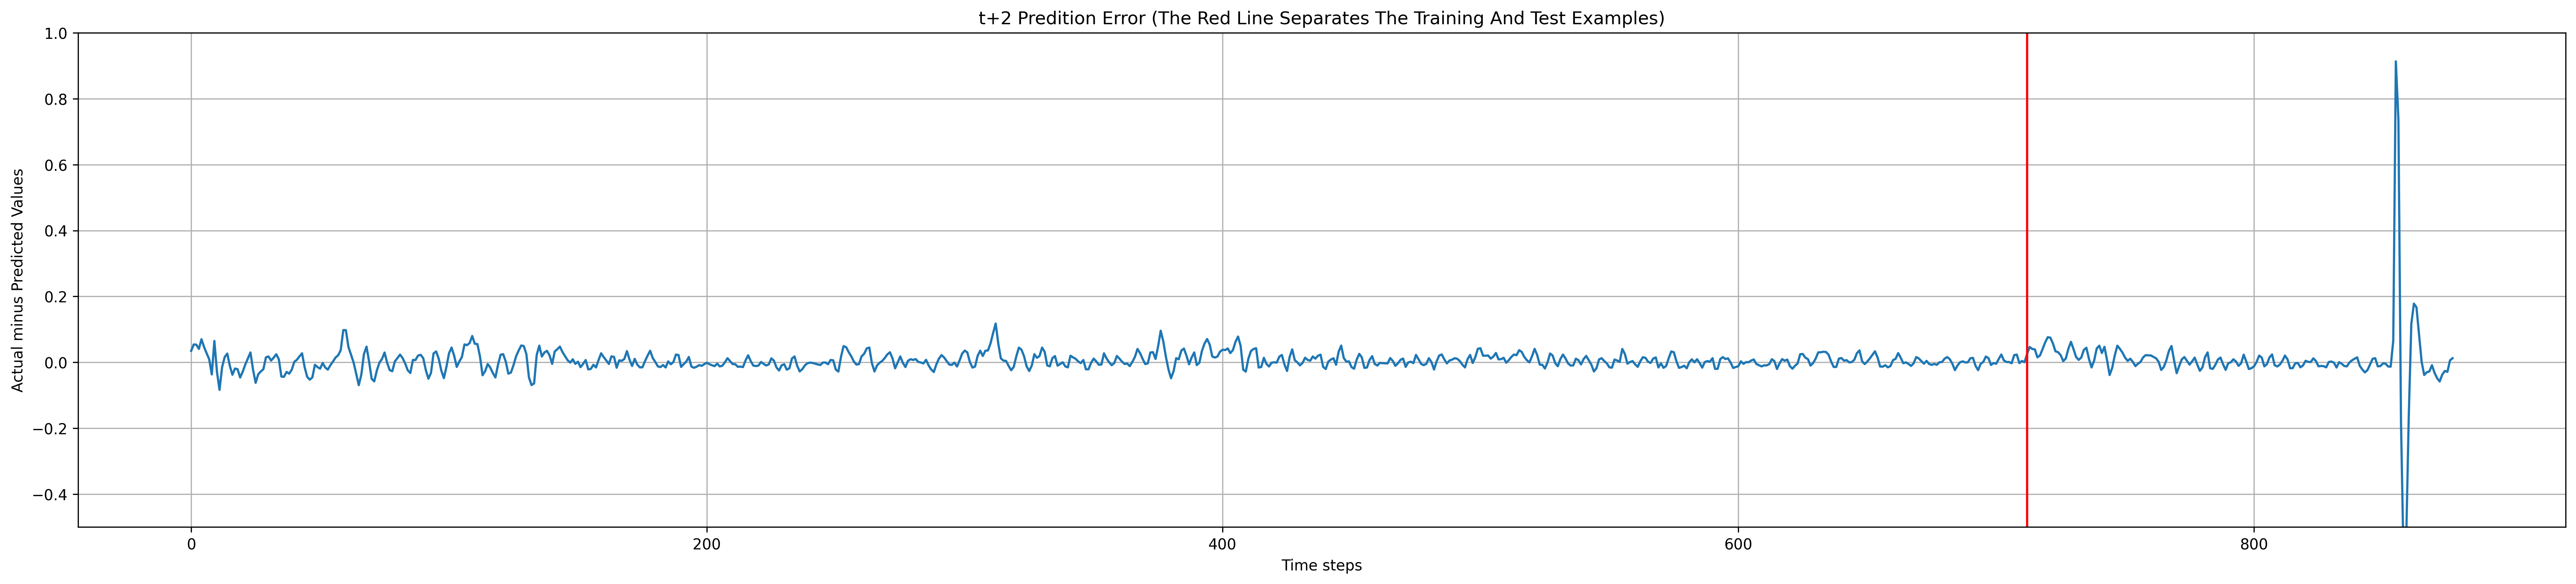

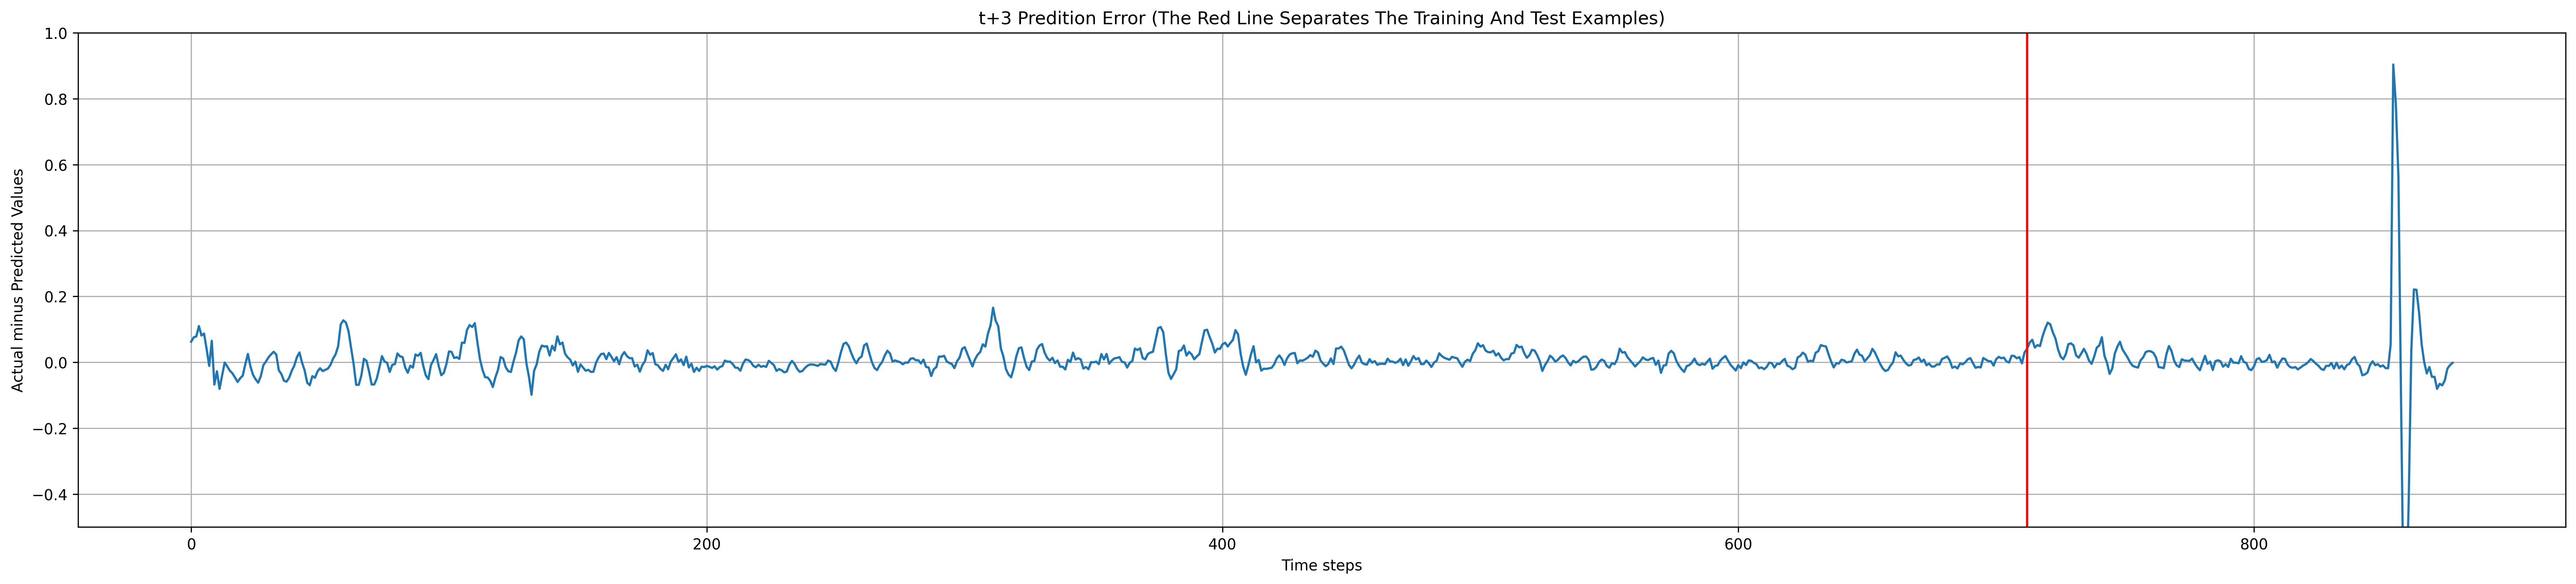

In [ ]:
# Plot the prediction error
def plot_result2(trainY, testY, train_predict, test_predict,i):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(30, 6), dpi=300)
    plt.plot(range(rows), actual - predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.xlabel('Time steps')
    plt.ylabel('Actual minus Predicted Values')
    plt.title('t+%d Predition Error (The Red Line Separates The Training And Test Examples)' % (i+1))
    plt.ylim(-0.5, +1.0) # Please, set the interval appropriately, considering all the graphs.
    plt.grid(True)

for i in range(horizon):
  if(horizon == 1):
    y1_pred = train_predict
    y1_pred_t = test_predict
    y1 = y
    y1_t = yt
  elif(horizon > 1):
    y1_pred = train_predict[:,i]
    y1_pred_t = test_predict[:,i]
    y1 = y[:,i]
    y1_t = yt[:,i]
  plot_result2(y1, y1_t, y1_pred, y1_pred_t,i)

In [ ]:
# Meaningful only for the simple RNN model (not for LP, MLP, ESN or LSTM)
wx = model.get_weights()[0]
wh = model.get_weights()[1]
bh = model.get_weights()[2]
wy = model.get_weights()[3]
by = model.get_weights()[4]
print(wx.shape)
print(wh.shape)
print(bh.shape)
print(wy.shape)
print(by.shape)

(1, 100)
(25, 100)
(100,)
(25, 3)
(3,)


**(C)** Qual a diferença no uso do parâmetro **time_steps** no caso dos **preditores não-recorrentes** e no caso do bloco LSTM?

A diferença no uso do parâmetro **time_steps** entre **preditores não-recorrentes** e o bloco LSTM está relacionada à **consideração da dependência temporal**.

Preditores não-recorrentes, como **MLP** e **LP**, tratam cada entrada de forma independente e não consideram a dependência temporal. Portanto, o parâmetro time_steps não é relevante nesses casos.

Por outro lado, o **bloco LSTM é projetado para lidar com sequências de dados** e leva em conta a dependência temporal. No bloco LSTM, o parâmetro **time_steps** define o número de passos de tempo (ou histórico) considerados como entrada. Cada passo de tempo corresponde a uma observação na sequência temporal.

Em resumo, nos preditores não-recorrentes, o parâmetro **time_steps** não é relevante, enquanto no bloco **LSTM**, ele define o tamanho do histórico considerado para fazer previsões.